In [1]:
import datetime as dt
import os

import src.project_definitions as eb

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib import ticker


from src import style, graphs
import src.update_databases as update
import src.utilities as ut
import src.sensor_reader as sr

import warnings
warnings.filterwarnings('ignore')

style.set_rc_eb_standard()

Tinkerforge up-to-date
EnergyMeter up-to-date


# Analyse der zusätzlich installierten Sensoren (Dezember 2021)
## 1. Abweichung der Luftfeuchten zwischen Gesamtsystem und Einzelsensor

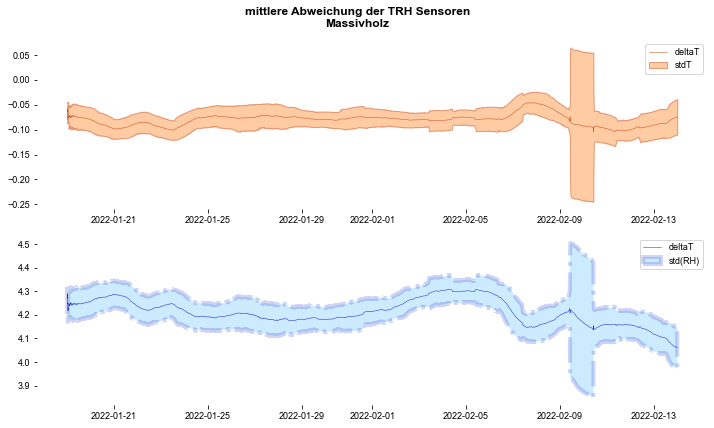

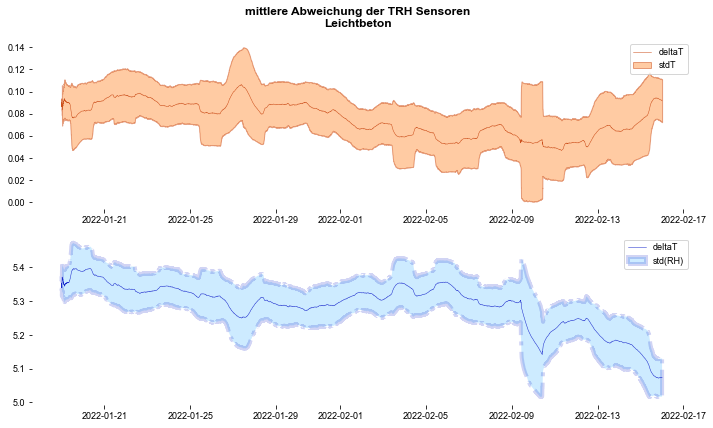

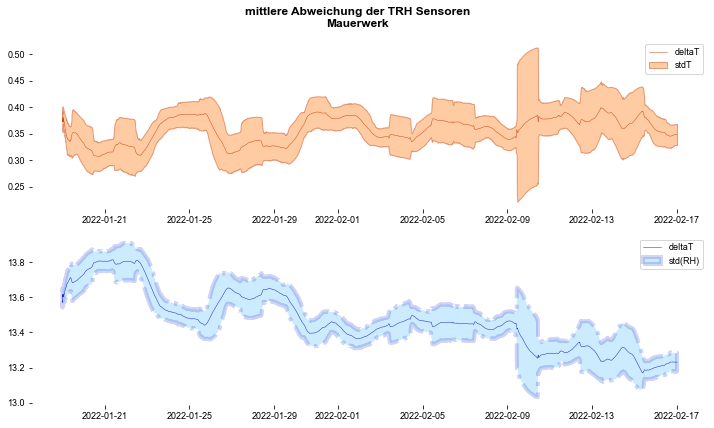

In [2]:
buid = ['MH','LB','MW']
#buid = ['MH']
mittlere_abweichung = {}
TEMP = []
RH = []
for bui in buid:
    df = sr.load_tf_bui(bui,'1min')

    fig, axs = plt.subplots(2)
    fig.suptitle(f'mittlere Abweichung der TRH Sensoren\n{eb.buid[bui]}')
    temp = df['O']['SWK'].filter(like='Tair').filter(like='trh')
    
    temp = temp.diff(axis=1).dropna(how='all',axis=1).dropna(axis=0)
    #temp = temp.mean(axis=1).dropna()
    temp.columns = [f'{bui}_deltaT']
    TEMP.append(temp)
    dot = temp.index
    mean = temp.rolling('24H').mean()
    error = temp.rolling('24H').std()

    axs[0].plot(mean, color='#CC4F1B',label = 'deltaT')
    axs[0].fill_between(dot, np.array(mean-error).flatten(), np.array(mean+error).flatten(), alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848', label='stdT')
    axs[0].legend()

    rh = df['O']['SWK'].filter(like='RH').filter(like='trh')

    rh = rh.diff(axis=1).dropna(how='all',axis=1).dropna(axis=0)
    #rh = rh.mean(axis=1).dropna()
    rh.columns = [f'{bui}_deltaRH']
    RH.append(rh)
    dot = rh.index
    mean = rh.rolling('24H').mean()
    error = rh.rolling('24H').std()

    axs[1].plot(mean, color='#1B2ACC',label='deltaT')
    axs[1].fill_between(dot, np.array(mean-error).flatten(), np.array(mean+error).flatten(), alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF', linewidth=4, linestyle='dashdot', antialiased=True,label='std(RH)')
    axs[1].legend()

    fig.tight_layout()

In [3]:
def annotate_boxplot(bpdict, annotate_params=None,
                     x_offset=0.05, x_loc=0,
                     text_offset_x=35,
                     text_offset_y=20):
    """Annotates a matplotlib boxplot with labels marking various centile levels.

    Parameters:
    - bpdict: The dict returned from the matplotlib `boxplot` function. If you're using pandas you can
    get this dict by setting `return_type='dict'` when calling `df.boxplot()`.
    - annotate_params: Extra parameters for the plt.annotate function. The default setting uses standard arrows
    and offsets the text based on other parameters passed to the function
    - x_offset: The offset from the centre of the boxplot to place the heads of the arrows, in x axis
    units (normally just 0-n for n boxplots). Values between around -0.15 and 0.15 seem to work well
    - x_loc: The x axis location of the boxplot to annotate. Usually just the number of the boxplot, counting
    from the left and starting at zero.
    text_offset_x: The x offset from the arrow head location to place the associated text, in 'figure points' units
    text_offset_y: The y offset from the arrow head location to place the associated text, in 'figure points' units
    """
    if annotate_params is None:
        annotate_params = dict(xytext=(text_offset_x, text_offset_y), textcoords='offset points', arrowprops={'arrowstyle':'->'})

    plt.annotate('Median', (x_loc + 1 + x_offset, bpdict['medians'][x_loc].get_ydata()[0]), **annotate_params)
    plt.annotate('25%', (x_loc + 1 + x_offset, bpdict['boxes'][x_loc].get_ydata()[0]), **annotate_params)
    plt.annotate('75%', (x_loc + 1 + x_offset, bpdict['boxes'][x_loc].get_ydata()[2]), **annotate_params)
    plt.annotate('5%', (x_loc + 1 + x_offset, bpdict['caps'][x_loc*2].get_ydata()[0]), **annotate_params)
    plt.annotate('95%', (x_loc + 1 + x_offset, bpdict['caps'][(x_loc*2)+1].get_ydata()[0]), **annotate_params)

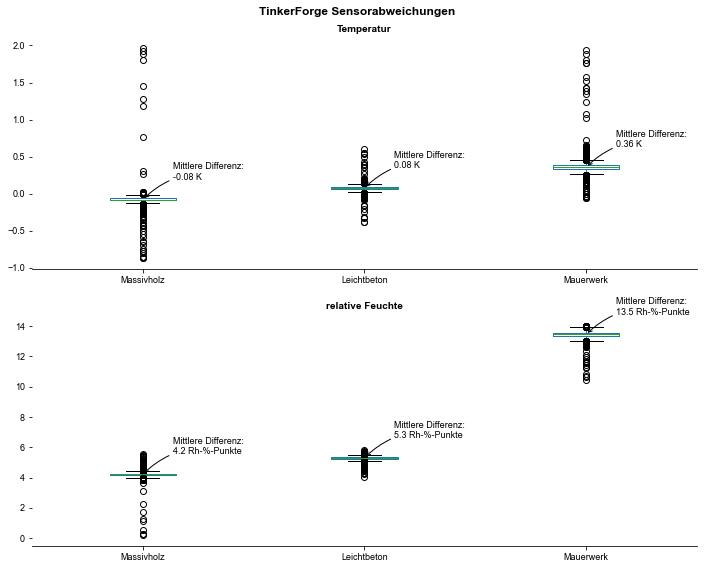

In [7]:
fig, axs = plt.subplots(2,1, figsize = (10,8))
fig.suptitle('TinkerForge Sensorabweichungen')
axs[0].set_title('Temperatur')
box_temp = pd.concat(TEMP)
box_temp.columns = ['Massivholz', 'Leichtbeton', 'Mauerwerk']
for i, (name, value) in enumerate(box_temp.mean().iteritems()):
    axs[0].annotate(f'Mittlere Differenz:\n{value:.2f} K', (i+1,value),xycoords='data', xytext=(30, 20), textcoords='offset points',arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=.2"))
box_temp.boxplot(ax=axs[0],grid=False)
axs[1].set_title('relative Feuchte')
box_hum = pd.concat(RH)
box_hum.columns = ['Massivholz', 'Leichtbeton', 'Mauerwerk']
box_hum.boxplot(ax=axs[1],grid=False)
for i, (name, value) in enumerate(box_hum.median().iteritems()):
    axs[1].annotate(f'Mittlere Differenz:\n{value:.1f} Rh-%-Punkte', (i+1,value),xycoords='data', xytext=(30, 20), textcoords='offset points',arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=.2"))

for ax in axs:
    ax.spines['bottom'].set_visible(True)
fig.tight_layout()
fig.savefig(os.path.join(eb.dir_results,'Allgemein','TinkerForge_Abweichungen.pdf'),dpi=300)

# Vergleich der Temperaturmessung im Dach

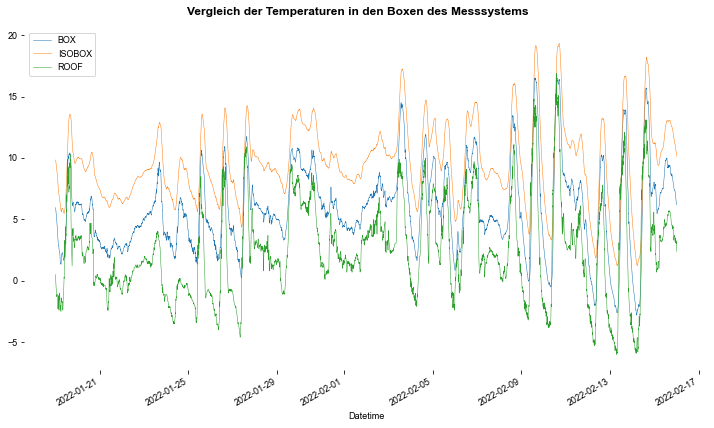

In [5]:
roof_climate = pd.merge(df['DA'], sr.load_tf_weather('1min')[['Rh_amb','T_amb']], left_index=True, right_index=True).dropna()
roof_climate.columns = pd.MultiIndex.from_tuples([('BOX','RH'), ('BOX','TEMP'), ('ISOBOX','RH'), ('ISOBOX','TEMP'), ('ROOF','RH'), ('ROOF','TEMP')]).swaplevel(0,1)
roof_climate.sort_index(axis=1)

fig, ax = plt.subplots()
roof_climate['TEMP'].plot(ax = ax)
fig.suptitle('Vergleich der Temperaturen in den Boxen des Messsystems')
fig.tight_layout()

<AxesSubplot:xlabel='Datetime'>

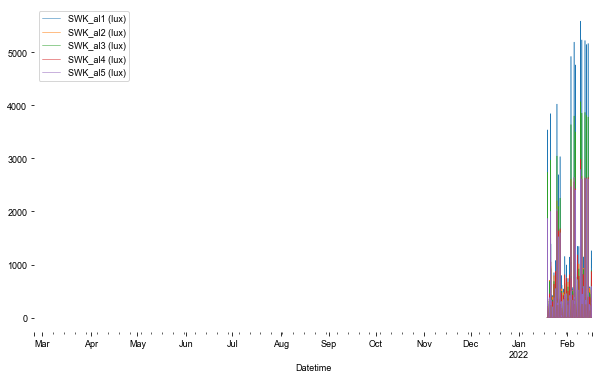

In [6]:
sr.load_tf_bui('MW')['O'][''].filter(like='lux').plot()